# PW4 NLP
**Maud Tissot**

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.14.0


## Téléchargez et explorez le jeu de données IMDB

In [8]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url,untar=True, cache_dir='.',cache_subdir='')
dataset_dir = os.path.join(os.path.dirname("aclImdb"), 'aclImdb')


In [9]:
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'test', 'README', 'imdbEr.txt']

In [10]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsupBow.feat',
 'urls_unsup.txt',
 'urls_pos.txt',
 'pos',
 'labeledBow.feat',
 'unsup',
 'neg',
 'urls_neg.txt']

In [11]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Charger le jeu de données

In [12]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [13]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [14]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [15]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


train

In [16]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Test

In [18]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Préparer l'ensemble de données pour la formation

In [19]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [20]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [21]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [22]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [23]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [24]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [25]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configurer l'ensemble de données pour les performances

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Créer le modèle

In [28]:
embedding_dim = 16

In [29]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
______________

## Fonction de perte et optimiseur

In [30]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Former le modèle

In [31]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 12s 15ms/step - loss: 0.6633 - binary_accuracy: 0.6956 - val_loss: 0.6139 - val_binary_accuracy: 0.7692
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.5480 - binary_accuracy: 0.8001 - val_loss: 0.4978 - val_binary_accuracy: 0.8218
Epoch 3/10
625/625 [==============================] - 5s 7ms/step - loss: 0.4450 - binary_accuracy: 0.8466 - val_loss: 0.4199 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3776 - binary_accuracy: 0.8665 - val_loss: 0.3735 - val_binary_accuracy: 0.8616
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3356 - binary_accuracy: 0.8788 - val_loss: 0.3448 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3052 - binary_accuracy: 0.8892 - val_loss: 0.3257 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 6s 10

## Évaluer le modèle

In [32]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3103 - binary_accuracy: 0.8732
Loss:  0.31032806634902954
Accuracy:  0.873199999332428


## Créer un graphique de précision et de perte au fil du temps

In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

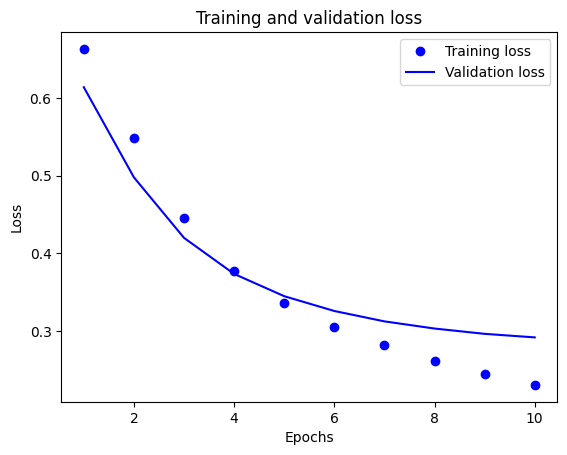

In [34]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

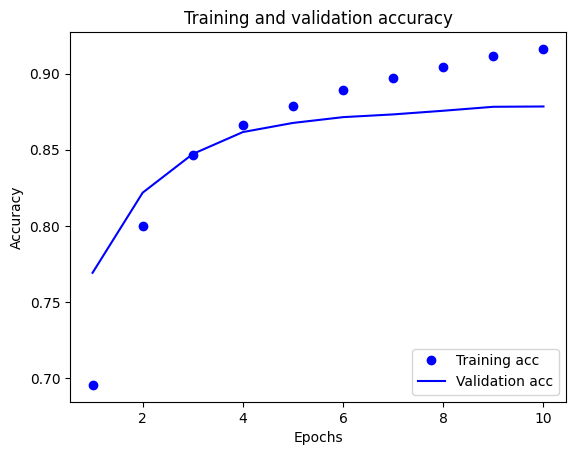

In [35]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()